# Liver-patient health


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold


In [ ]:
# Define column names according to the satement
columns = ["Age", "Female", "TB", "DB", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/R"]

train_features = pd.read_csv("train_features_ILDS.csv", header=None, names=columns)

train_labels = pd.read_csv("train_labels_ILDS.csv", header=None, names=["Label"])

test_data = pd.read_csv("test_data_ILDS.csv", header=None, names=columns)

print("Train features:")
print(train_features.head())

print("\nTrain labels:")
print(train_labels.head())

print("\nTest data:")
print(test_data.head())



Train features:
   Age  Female   TB   DB  Alkphos  Sgpt  Sgot   TP  ALB   A/R
0   40       0  3.9  1.7      350   950  1500  6.7  3.8  1.30
1   48       0  4.5  2.3      282    13    74  7.0  2.4  0.52
2   39       0  1.9  0.9      180    42    62  7.4  4.3  1.38
3   23       0  1.0  0.3      212    41    80  6.2  3.1  1.00
4   42       1  0.7  0.2      152    35    81  6.2  3.2  1.06

Train labels:
   Label
0      0
1      0
2      0
3      0
4      0

Test data:
   Age  Female   TB   DB  Alkphos  Sgpt  Sgot   TP  ALB   A/R
0   11       0  0.7  0.1      592    26    29  7.1  4.2  1.40
1   62       0  1.8  0.9      224    69   155  8.6  4.0  0.80
2   60       0  0.7  0.2      174    32    14  7.8  4.2  1.10
3   60       0  5.7  2.8      214   412   850  7.3  3.2  0.78
4   48       1  0.9  0.2      175    24    54  5.5  2.7  0.90


We focus on the training set, where we observe that some individuals have values for certain parameters that deviate significantly from the mean. These may be potential outliers. Therefore, we proceed with an outlier detection procedure.

In [ ]:
print(train_features.describe())

              Age      Female          TB          DB      Alkphos  \
count  463.000000  463.000000  463.000000  463.000000   463.000000   
mean    44.881210    0.241901    3.278834    1.445788   279.866091   
std     16.308741    0.428698    6.114760    2.675304   211.283163   
min      4.000000    0.000000    0.400000    0.100000    75.000000   
25%     33.000000    0.000000    0.800000    0.200000   176.000000   
50%     45.000000    0.000000    1.000000    0.300000   208.000000   
75%     57.500000    0.000000    2.700000    1.300000   291.000000   
max     90.000000    1.000000   75.000000   18.300000  1630.000000   

              Sgpt         Sgot          TP         ALB         A/R  
count   463.000000   463.000000  463.000000  463.000000  463.000000  
mean     75.844492    97.606911    6.422030    3.109935    0.942916  
std     169.289826   212.114404    1.051648    0.793036    0.318381  
min      10.000000    11.000000    2.700000    0.900000    0.300000  
25%      23.000000 

## Preprocessing
Since missing values have been handled and categorical features have been transformed into numerical format, we now proceed with further data preporcessing after doing an initial exploratory analysis.

One possible step would be to identify and remove outliers. However, in the medical field, extreme values can often be clinically relevant rather than erroneous. Therefore, without close collaboration with domain experts, it is better not to discard such data.

Nevertheless, we will visualize the distributions of variables using histograms, distinguishing between ill and noon-ill individuals, to better understand how each variable behaves depending on the health status of the individual.

### Outliers detection
**Model Based: Local Outlier Factor**
Since sometimes the classic approaches (IQR) are not enough we need a more complex approach in order not to take variables independently. Here we use Local Outlier Factor which uses the local density of a point to decide whether it is an outlier or not. The local density is calculated by using its k nearest neighbors.

Here we can clearly see a large number of outlying observations that could be relevant.

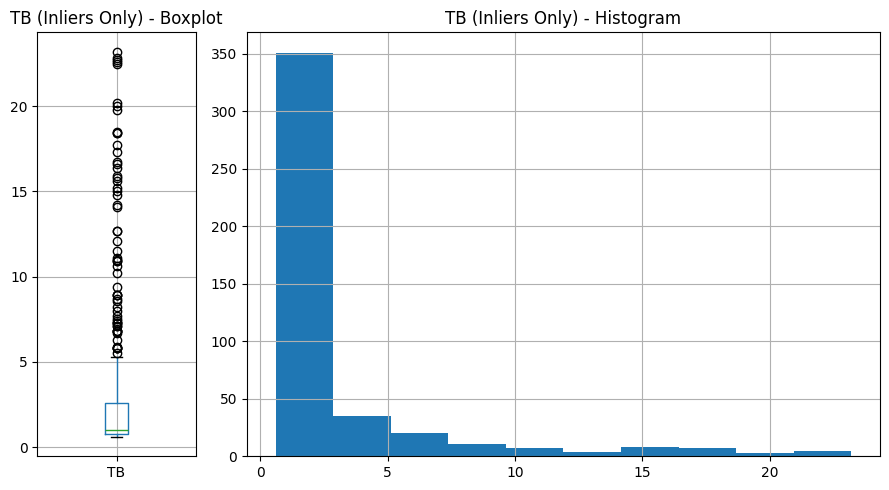

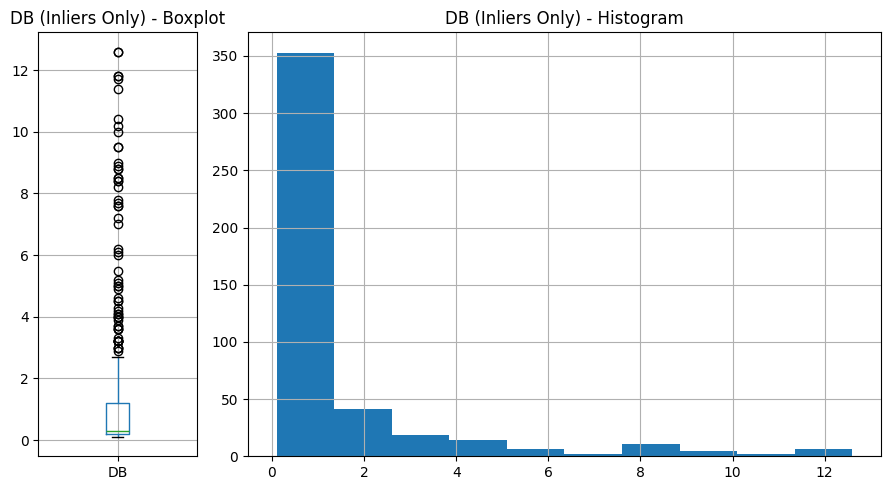

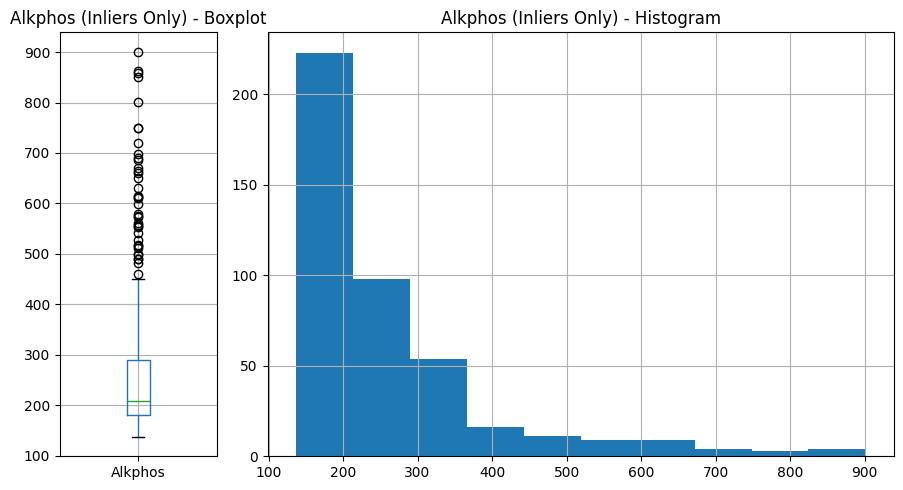

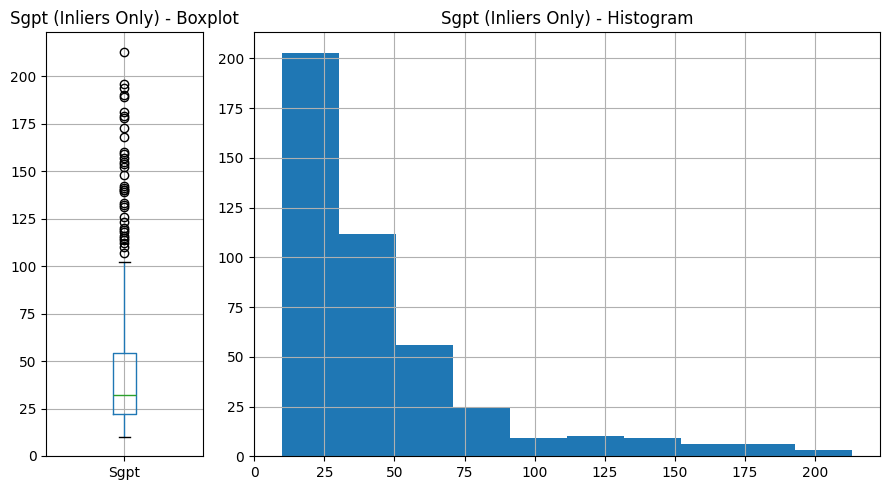

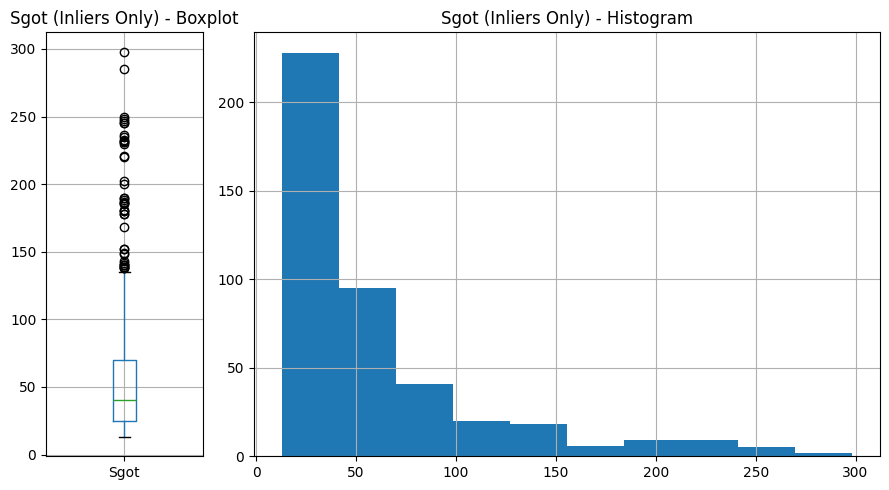

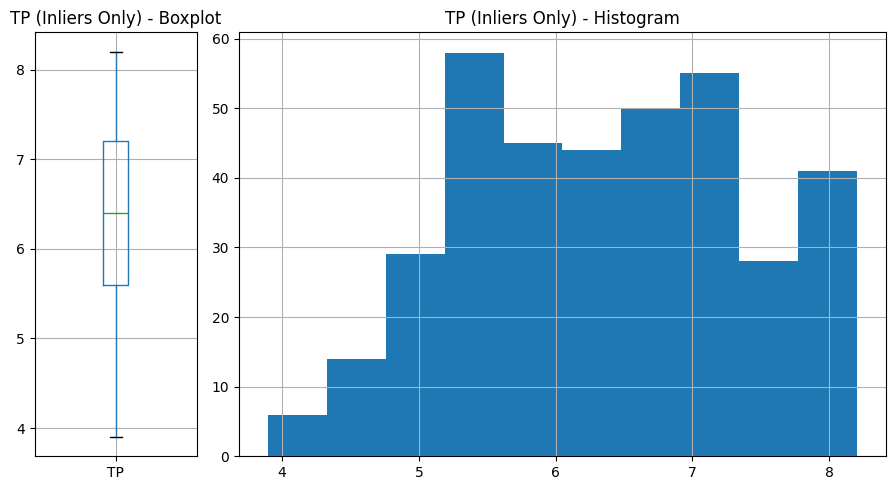

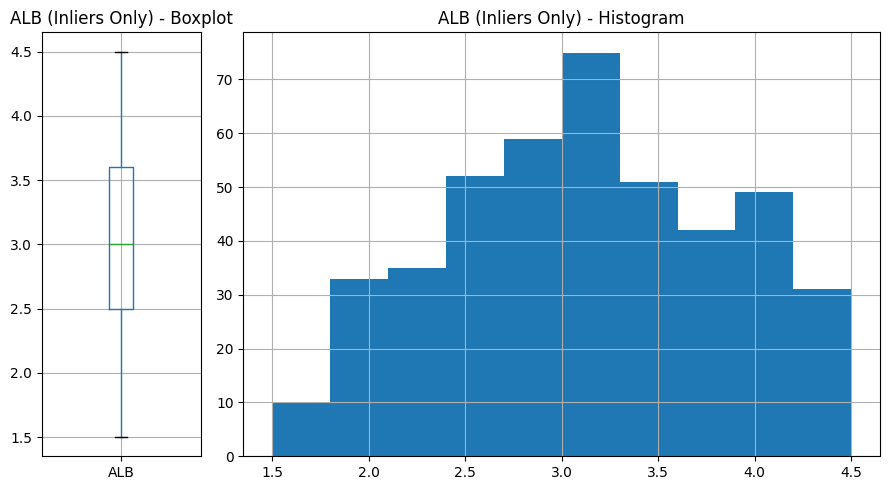

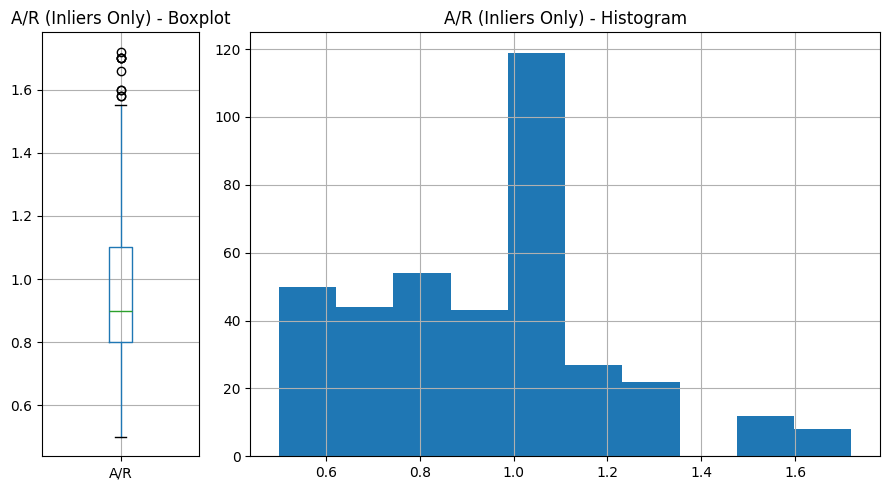

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Variables to analyze (exclude 'Age' and 'Female')
columns_to_check = [col for col in train_features.columns if col not in ['Age', 'Female']]

# Loop through each variable
for col in columns_to_check:
    # Apply LOF to the variable
    lof = LocalOutlierFactor(n_neighbors=20)
    result = lof.fit_predict(train_features[col].values.reshape(-1, 1))

    # Get mask for inliers
    no_outliers = result == 1

    # Create plots
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))

    # Boxplot and histogram for inliers only
    train_features[no_outliers].boxplot(column=col, ax=axes[0])
    train_features[no_outliers].hist(column=col, ax=axes[1])

    # Add titles
    axes[0].set_title(f'{col} (Inliers Only) - Boxplot')
    axes[1].set_title(f'{col} (Inliers Only) - Histogram')

    # Adjust layout and show
    plt.tight_layout()
    plt.show()



### Histogram info

These histograms provide several insights into the distribution of the clinical features by health status:

- TB (Total Bilirubin): there is a noticeable ill patient with a TB level around 70, which is higher than the majority. data is observed around 70.
- DB (Direct Bilirubin): the distribution is dispers, indicating high variability in this marker.
- Alkphos (Alkaline Phosphotase): surprisingly, there is a healthy patient with a very high Alkphos value (~1600). Additionally, several liver patients have unique, isolated high values that don't match the rest of the group.
- Sgpt: some extreme outliers are observed at 800, 1300, and 1650, which are significantly higher than typical values, suggesting individual abnormalities.
- Albumin: the distribution is diverse with no clear separation. It might be a less discriminative variable.  
- A/R: some observations are around 2.5 and 2.75, which seem inconsistent with the rest of the data.

Even though some values look like outliers, we choose not to remove them at this stage. Since we are not domain experts (doctors or medical researchers), we prefer to retain all data points. These unusual values might represent important clinical conditions that could be crucial for diagnosis and, therefore, for building an accurate model.

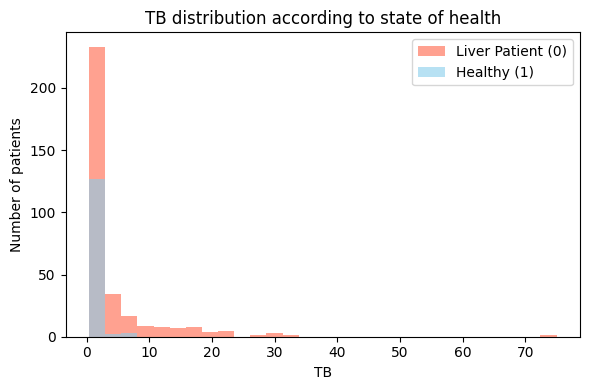

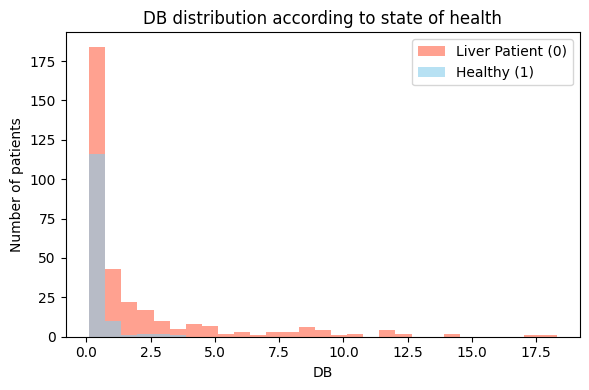

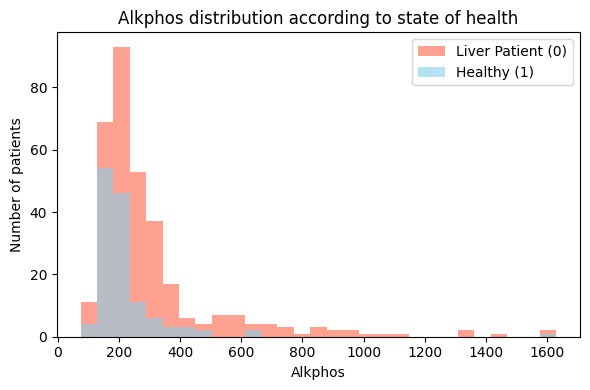

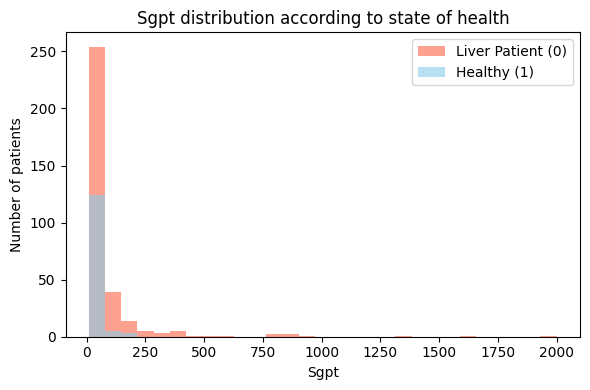

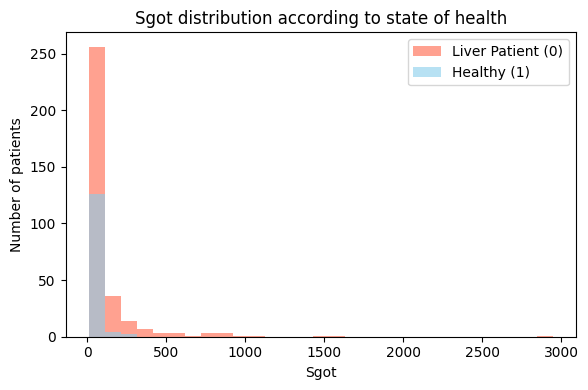

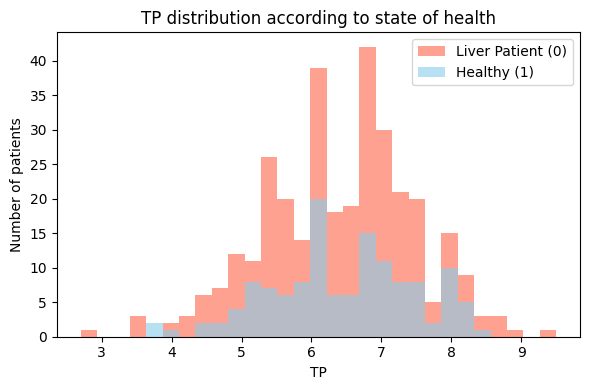

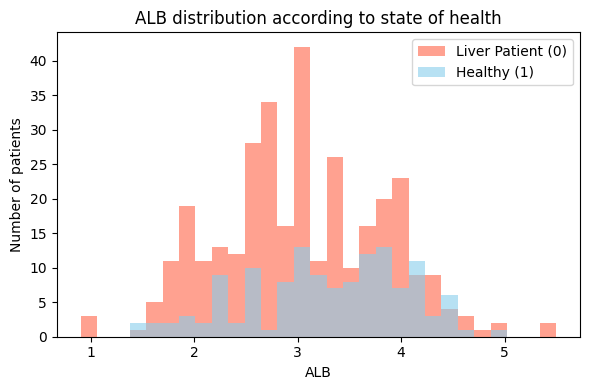

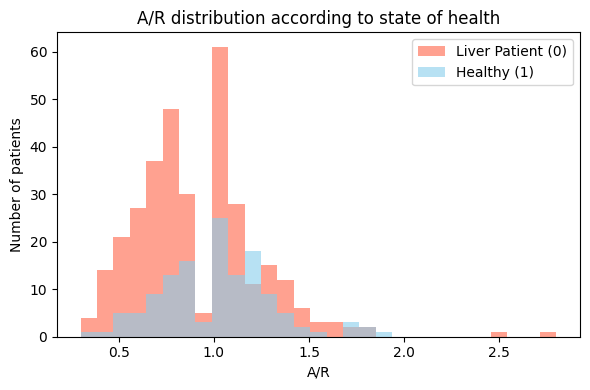

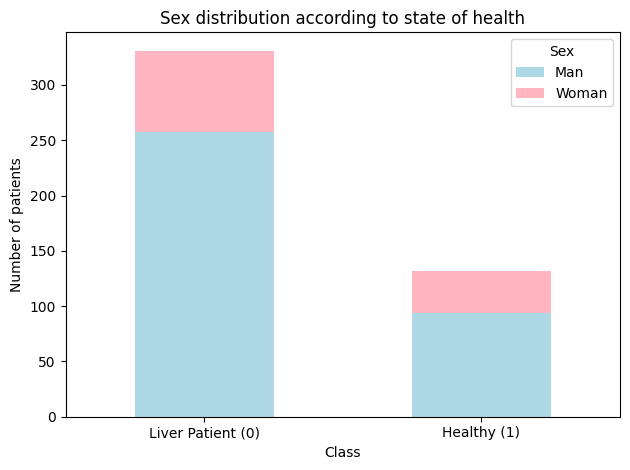

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Join variables + lable
train = pd.concat([train_features, train_labels], axis=1)

# Clinical variables
clinical_features = ["TB", "DB", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/R"]

for col in clinical_features:
    min_val = train[col].min()
    max_val = train[col].max()
    bins = np.linspace(min_val, max_val, 30)

    plt.figure(figsize=(6, 4))
    plt.hist(train[train["Label"] == 0][col], bins=bins, alpha=0.6, label="Liver Patient (0)", color='tomato')
    plt.hist(train[train["Label"] == 1][col], bins=bins, alpha=0.6, label="Healthy (1)", color='skyblue')
    plt.title(f"{col} distribution according to state of health")
    plt.xlabel(col)
    plt.ylabel("Number of patients")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Female and male according to the class
sex_counts = train.groupby(["Label", "Female"]).size().unstack()
sex_counts.columns = ["Man", "Woman"]

# Barplot
sex_counts.plot(kind="bar", stacked=True, color=["lightblue", "lightpink"])
plt.title("Sex distribution according to state of health")
plt.xlabel("Class")
plt.ylabel("Number of patients")
plt.xticks(ticks=[0, 1], labels=["Liver Patient (0)", "Healthy (1)"], rotation=0)
plt.legend(title="Sex")
plt.tight_layout()
plt.show()


#### Transformations and gaussianity
It is always highly recommened to scale or transform variables, especially considering the requirements of the machine learning models being used.

Models such as Logistic Regression, LDA, QDA, K-NN, Gaussian NB and Super Vector Machines (SVM, both linear and non-linear) are sensitive to the scale and distribution of the input features. These algorithms often assume features are normally disstributed and can be adversely affected by outliers and skewed data.

In contrast, tree-based classifiers such as Decision Tree, Random Forest, Extra Trees and Gradient Boosting, are generally insensitive to feature scaling and distribution, as they split data based on thresholds rather than distance or probability assumptions.

Therefore, we will apply transformations and scaling only for models that require it.


**HISTOGRAM ANALYSIS AND TRANSFORMATION DECISIONS**:


*   **TP, ALB**: these features roughly symmetric, unimodal, closely bell-shaped. Since they are already close to a normal distribtuion, no transformation is needed.
*   **TB, DB, Alkphos, Sgpt, Sgot**: these features are highly positively skewed (long right tail, many low values, few very high values). Such skewness can negatively impact models that assume normality or are sensitive to outliers.
*  **A/R**: this feature is moderately right-skewed, but not as extreme as the previous ones.

While RobustScaler is effective at handling outliers by using the median and interquartile range for scaling, it does not address the issue of skewness or non-normality in feature distributions. For features that are highly skewed, like the previously mentioned ones, it is more appropriate to use a transformation that can normalize the distribution.

Box-Cox transformation is specifically used to reduce skewness and make data more Gaussian-like, in order to stabilize variance, reduce the influence of extreme values and improve the performance of sensitive models.

Therefore, we will apply Box-Cox transformation to the skewed variables (TB, DB, Alkphos, Sgpt, Sgot, A/R) and scale the remaining ones (TP, ALB) with RobustScaler.

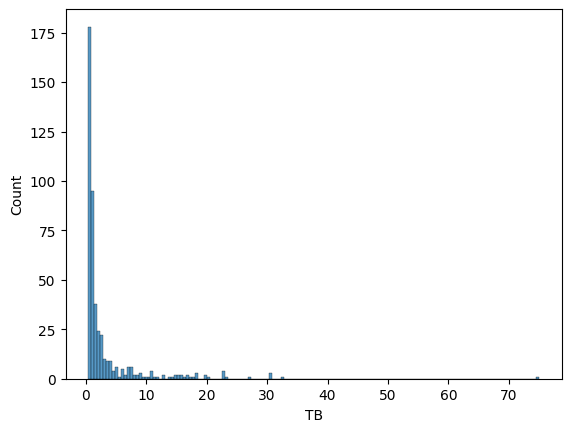

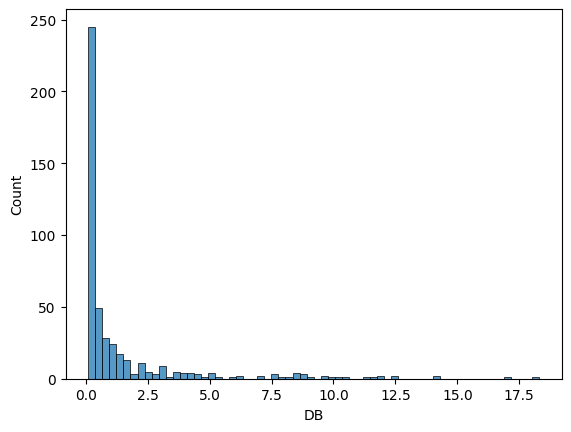

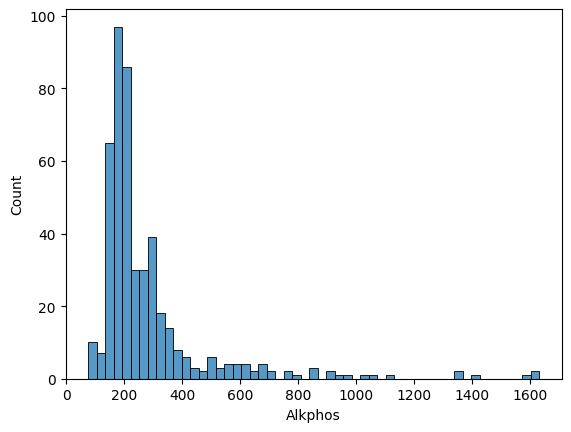

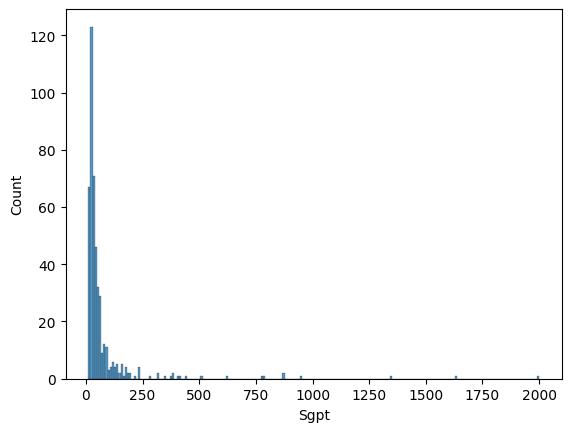

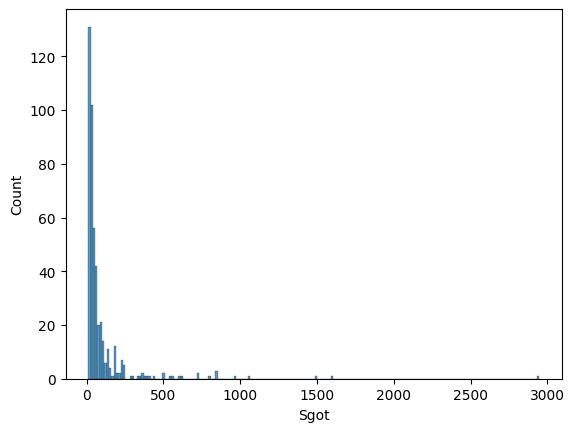

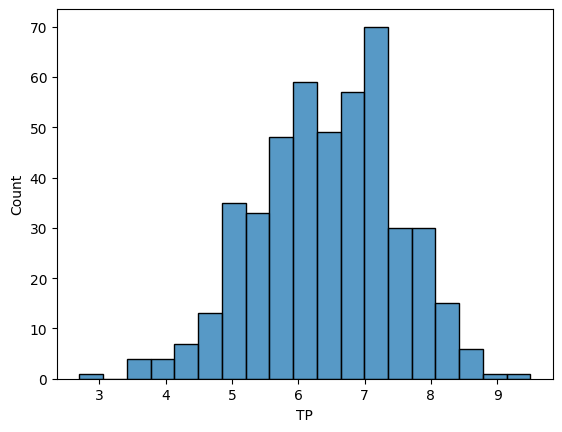

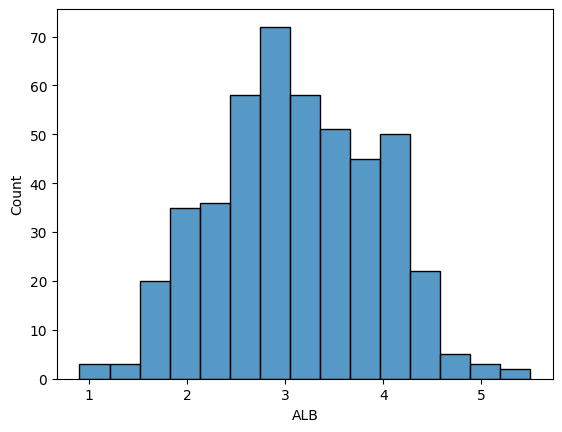

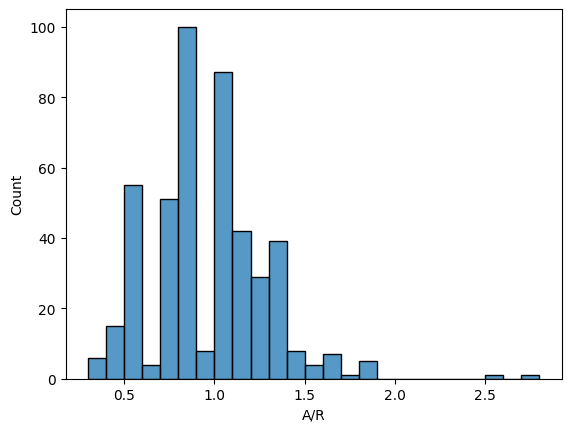

In [ ]:
# Check feature distributions
import seaborn as sns
for col in clinical_features:
    sns.histplot(train_features[col])
    plt.show()

To optimize preprocessing for each model we need to transform the models according to their requirements and characteristics.

### Normalization and scaling
It has been seen that although applying a box-cox transformation TB and DB are still not normal. Consequetly, we apply a logarithm transformation which it turns out to be useless aswell. Finally we have used a quantile transformation and we finally can say that have achieved almost normallity for all our variables.

In [ ]:
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.preprocessing import QuantileTransformer

# List of columns to transform
boxcox_cols = ["Alkphos", "Sgpt", "Sgot", "A/R"]
log_cols = ["TB", "DB"]
other = ["TP", "ALB"]

# Copy for transformations
train_box_scaler = train_features.copy()
test_box_scaler = test_data.copy()

# Box-Cox transformation for skewed columns
pt = PowerTransformer(method='box-cox')

train_box_scaler[boxcox_cols] = pt.fit_transform(train_box_scaler[boxcox_cols])
test_box_scaler[boxcox_cols] = pt.transform(test_box_scaler[boxcox_cols])

# Log transformation for columns that don't work with box-cox
qt = QuantileTransformer(output_distribution='normal', random_state=0)
train_box_scaler[log_cols] = qt.fit_transform(train_box_scaler[log_cols])
test_box_scaler[log_cols] = qt.transform(test_box_scaler[log_cols])

# Scale all columns
scaler = RobustScaler()
train_box_scaler[clinical_features] = scaler.fit_transform(train_box_scaler[clinical_features])
test_box_scaler[clinical_features] = scaler.transform(test_box_scaler[clinical_features])

train_box_scaler.describe()

,Age,Female,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/R
count,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000
mean,44.881210,0.241901,0.016757,-0.256733,0.126221,0.040490,0.028603,-0.055693,0.008279,-0.029415
std,16.308741,0.428698,0.854546,1.453085,0.833097,0.739832,0.665073,0.751177,0.660863,0.757736
min,4.000000,0.000000,-4.306311,-4.001970,-3.259513,-1.839660,-1.551184,-2.714286,-1.833333,-2.103480
25%,33.000000,0.000000,-0.414411,-0.434283,-0.375734,-0.467632,-0.477458,-0.571429,-0.500000,-0.586756
50%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,57.500000,0.000000,0.585589,0.565717,0.624266,0.532368,0.522542,0.428571,0.500000,0.413244
max,90.000000,1.000000,4.328839,4.060880,2.184416,1.845779,1.617435,2.142857,2.000000,3.018943


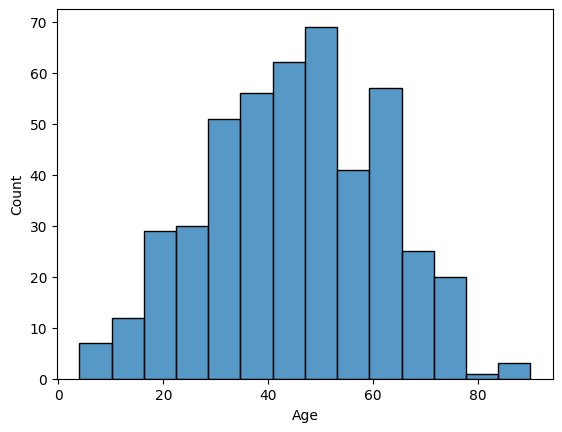

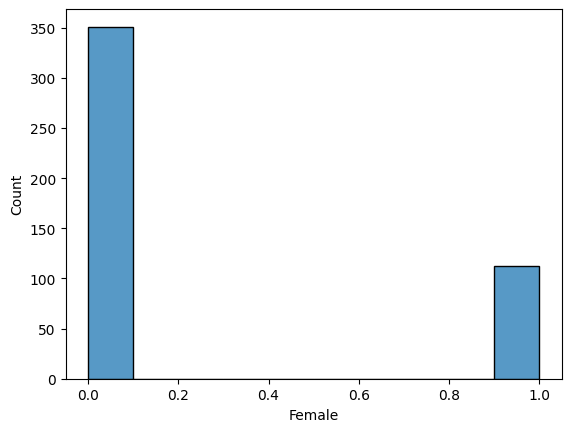

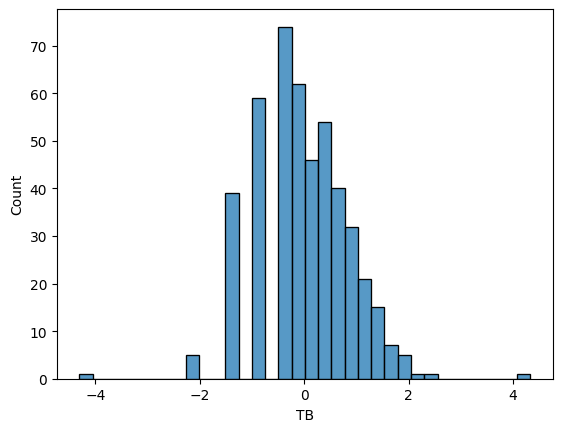

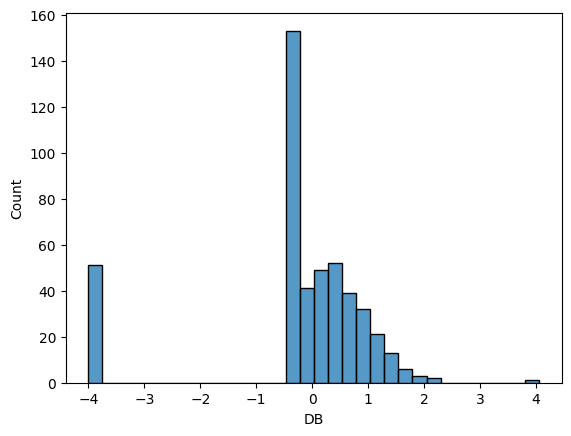

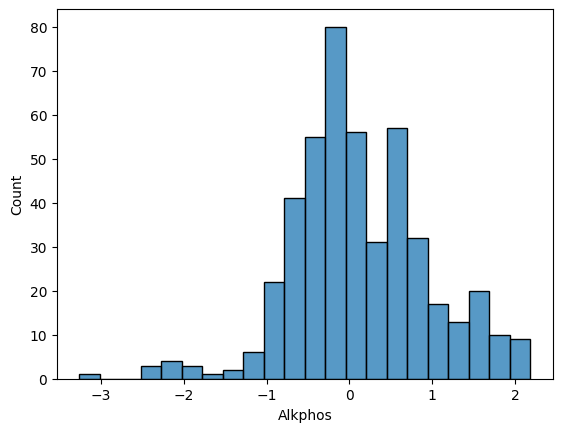

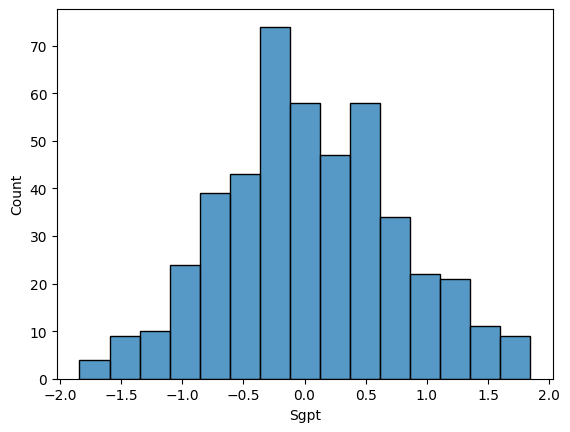

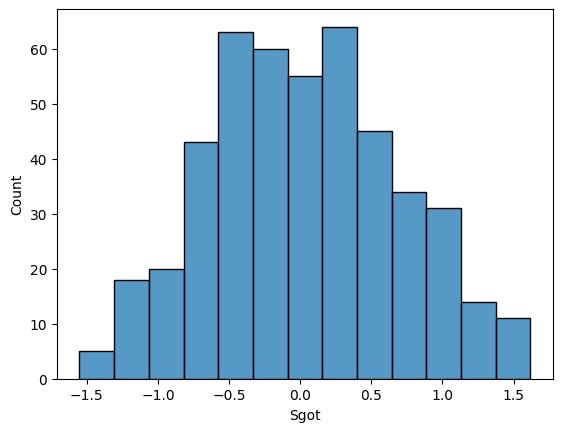

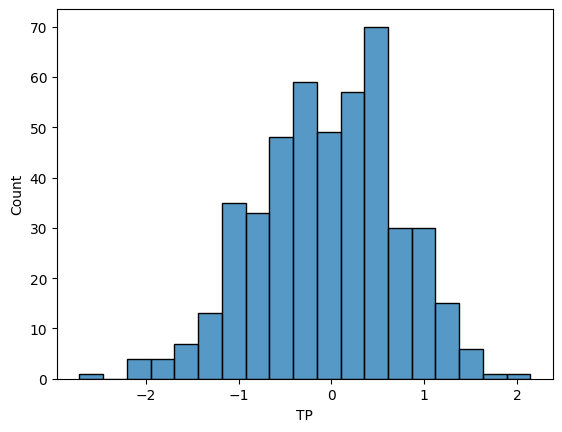

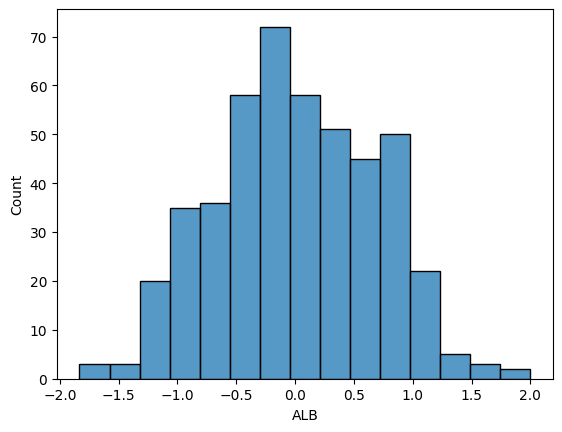

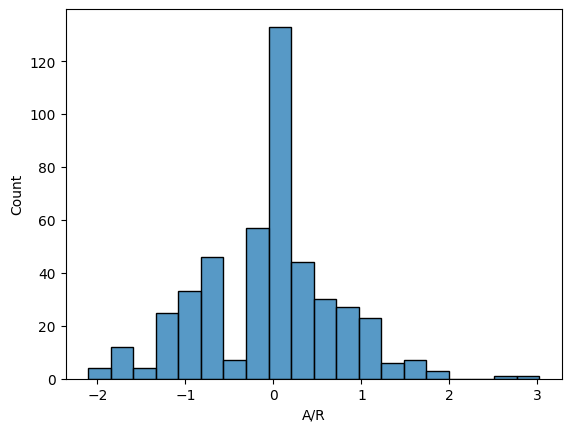

In [ ]:
for col in train_box_scaler.columns:
    sns.histplot(train_box_scaler[col])
    plt.show()

## Normalization

In [ ]:
# Copy for transformations
train_box = train_features.copy()
test_box = test_data.copy()

# Box-Cox transformation for skewed columns
pt = PowerTransformer(method='box-cox')

train_box[boxcox_cols] = pt.fit_transform(train_box[boxcox_cols])
test_box[boxcox_cols] = pt.transform(test_box[boxcox_cols])

# Log transformation for columns that don't work with box-cox
qt = QuantileTransformer(output_distribution='normal', random_state=0)
train_box[log_cols] = qt.fit_transform(train_box[log_cols])
test_box[log_cols] = qt.transform(test_box[log_cols])


### Correlation detection
The colineality can be a problem in models like logistic regression, LDA and QDA, because it can cause numerical problems as well as unstable coefficients.

We will start checking the VIF values and removing those variables with VIF > 10.

Afterwards, we will use correlation matrix to check which pairs are highly correlated.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_num = train_box_scaler[columns]

# VIF (Variance Inflation Factor)
X = sm.add_constant(df_num)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\nVIF for each variable:")
print(vif)


VIF for each variable:
   Variable        VIF
0     const  10.482459
1       Age   1.126735
2    Female   1.106309
3        TB   3.246249
4        DB   2.726063
5   Alkphos   1.342293
6      Sgpt   2.870515
7      Sgot   2.969218
8        TP   9.025569
9       ALB  20.223261
10      A/R   7.731617


Albumin VIF value is extremely high. Consequently, we will remove this variable.

In [ ]:
train_box_scaler_corr = train_box_scaler.drop(columns=["ALB"]).copy()
test_box_scaler_corr = test_box_scaler.drop(columns=["ALB"]).copy()

In [ ]:
print(test_box_scaler_corr)

     Age  Female        TB        DB   Alkphos      Sgpt      Sgot        TP  \
0     11       0 -0.813952 -4.001970  1.517438 -0.310740 -0.322734  0.428571   
1     62       0  0.354169  0.414971  0.151899  0.641258  0.857736  1.500000   
2     60       0 -0.813952 -0.434283 -0.403239 -0.066532 -1.193089  0.928571   
3     60       0  0.895133  0.860949  0.059310  1.520467  1.412763  0.571429   
4     48       1 -0.140510 -0.434283 -0.389417 -0.412047  0.222661 -0.714286   
..   ...     ...       ...       ...       ...       ...       ...       ...   
111   69       1 -0.414411 -0.434283 -0.857128  0.216373  0.408352  1.357143   
112   35       0  1.904437  1.775247 -1.794654  1.178163  1.343520  1.928571   
113   42       0 -0.414411 -0.434283 -1.610209 -0.590593 -0.569089  0.357143   
114   18       0 -1.322557 -0.434283  1.423505 -0.032503 -0.168142  0.714286   
115   32       0  1.885259  1.931949  1.463704  0.192866  0.554815  1.000000   

          A/R  
0    1.010994  
1   -0.

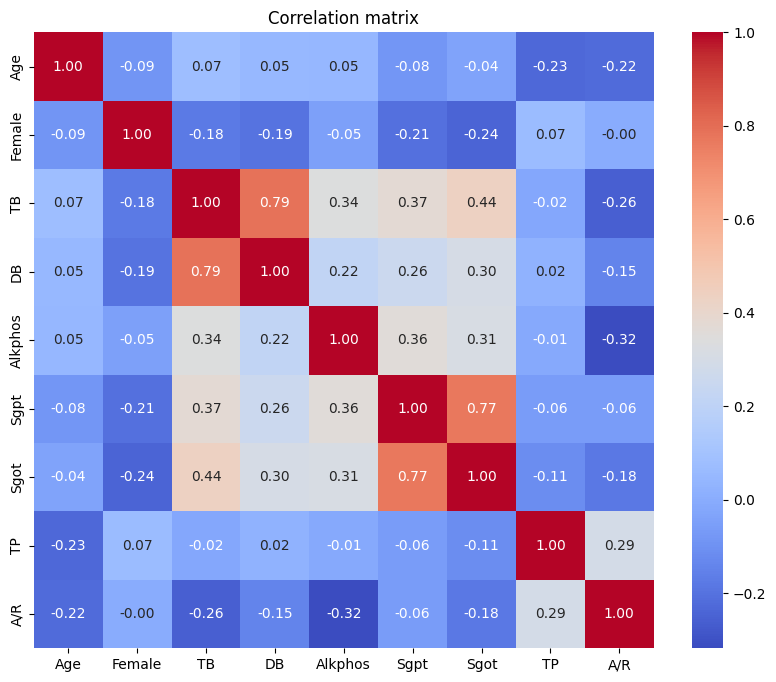

In [ ]:
# Correlation matrix
columns_reduced = [col for col in columns if col != "ALB"]
# Build the reduced DataFrame
df_num = train_box_scaler_corr[columns_reduced]
plt.figure(figsize=(10, 8))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix")
plt.show()

There are still highly correlated features (DB with TB and Sgot with Sgpt), reducing dimensionality is a good choice to fix it.

We are going to use PCA.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.98)  # Preserve 98% of variance
train_pca = pca.fit_transform(train_box_scaler_corr)
test_pca = pca.transform(test_box_scaler_corr)

print(f"Number of components after PCA: {pca.n_components_}")


Number of components after PCA: 2


## Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# TRANSFORMED DATA: BOX-COX # #test_box
X_train_box, X_val_box, y_train_box, y_val_box = train_test_split(
    train_box, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# TRANSFORMED DATA: BOX-COX + SCALING #test_box_scaler
# Stratify to preserve class proportions due to imbalance
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
    train_box_scaler, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# TRANSFORMED DATA: BOX-COX + SCALING + NO CORRELATION #test_pca
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(
    train_pca, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# NON-TRANSFORMED DATA #test_data
X_train_not, X_val_not, y_train_not, y_val_not = train_test_split(
    train_features, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Parametrized Gaussian models
We are going to start off with parametrized gaussian models: LDA, QDA and GNB

## LDA

In [ ]:
# Model initialization
lda_model = LinearDiscriminantAnalysis()

# Cross-validation
cv_results = cross_validate(
    lda_model, X_train_t, y_train_t, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# The mean for each metric
val_results = {
    'Accuracy': np.mean(cv_results['test_accuracy']),
    'F1 Macro': np.mean(cv_results['test_f1_macro']),
    'Precision Macro': np.mean(cv_results['test_precision_macro']),
    'Recall Macro': np.mean(cv_results['test_recall_macro'])
}

# Dataframe creation
results_df = pd.DataFrame(index=['LDA'], columns=['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])
results_df.loc['LDA'] = [
    val_results['Accuracy'],
    val_results['F1 Macro'],
    val_results['Precision Macro'],
    val_results['Recall Macro']
]

results_df


,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.743243,0.616191,0.707419,0.610872


 F1 macro score is much lower than accuracy, this suggests **class imbalance** or that LDA's assumptions (normality, equal class covariances, linear separability) may not hold for this dataset.

### LDA with uncorrelated data

In [ ]:
lda = LinearDiscriminantAnalysis()

# Cross-validation
cv_results = cross_validate(
    lda, X_train_pca, y_train_pca, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute means of CV metrics
cv_summary = {
    'Accuracy': cv_results['test_accuracy'].mean(),
    'F1 Macro': cv_results['test_f1_macro'].mean(),
    'Precision Macro': cv_results['test_precision_macro'].mean(),
    'Recall Macro': cv_results['test_recall_macro'].mean()
}

results_df.loc['LDA Uncorrelated', :] = [cv_summary['Accuracy'], cv_summary['F1 Macro'], cv_summary['Precision Macro'], cv_summary['Recall Macro']]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.743243,0.616191,0.707419,0.610872
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282


Reducing dimension in this case enworsens the results.

## QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
qda = QDA()

cv_results = cross_validate(
    qda, X_train_t, y_train_t, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute means of CV metrics
cv_summary = {
    'Accuracy': cv_results['test_accuracy'].mean(),
    'F1 Macro': cv_results['test_f1_macro'].mean(),
    'Precision Macro': cv_results['test_precision_macro'].mean(),
    'Recall Macro': cv_results['test_recall_macro'].mean()
}

results_df.loc['QDA', :] = [cv_summary['Accuracy'], cv_summary['F1 Macro'], cv_summary['Precision Macro'], cv_summary['Recall Macro']]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.743243,0.616191,0.707419,0.610872
QDA,0.651351,0.589366,0.587825,0.595597
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282


## QDA with uncorrelated data

In [ ]:
qda = QDA()

cv_results = cross_validate(
    qda, X_train_pca, y_train_pca, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute means of CV metrics
cv_summary = {
    'Accuracy': cv_results['test_accuracy'].mean(),
    'F1 Macro': cv_results['test_f1_macro'].mean(),
    'Precision Macro': cv_results['test_precision_macro'].mean(),
    'Recall Macro': cv_results['test_recall_macro'].mean()
}

results_df.loc['QDA Uncorrelated Data', :] = [cv_summary['Accuracy'], cv_summary['F1 Macro'], cv_summary['Precision Macro'], cv_summary['Recall Macro']]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.743243,0.616191,0.707419,0.610872
QDA,0.651351,0.589366,0.587825,0.595597
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282
QDA Uncorrelated Data,0.705405,0.473766,0.569795,0.515454


QDA outperforms LDA on Recall Macro, but is lower for the other metrics. Accuracy is higher for LDA than QDA but, since data is imbalanced, F1 is a more reliable metric. Both models show a notable drop in F1 macro compared to accuracy, indicating that performance is uneven across classes (likely lower on the minority class).
The low F1 macro for both suggests that further improvements could be achieved by addressing class imbalance (done later).
Dealing with uncorrelated data does not improve our result.

## Gaussian Naive Bayes

In [ ]:
gaussian_nb = GaussianNB()

# Perform cross-validation on the training data
cv_results_GNB = cross_validate(
    gaussian_nb, X_train_t, y_train_t, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute means of CV metrics
cv_summary_GNB = {
    'Accuracy': cv_results_GNB['test_accuracy'].mean(),
    'F1 Macro': cv_results_GNB['test_f1_macro'].mean(),
    'Precision Macro': cv_results_GNB['test_precision_macro'].mean(),
    'Recall Macro': cv_results_GNB['test_recall_macro'].mean()
}

results_df.loc['GNB', :] = [
    cv_summary_GNB['Accuracy'],
    cv_summary_GNB['F1 Macro'],
    cv_summary_GNB['Precision Macro'],
    cv_summary_GNB['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
QDA,0.651351,0.589366,0.587825,0.595597
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282
QDA Uncorrelated Data,0.705405,0.473766,0.569795,0.515454


GNB might not have the best accuracy but has the highest F1 Macro score, a more reliable measure for this unbalanced dataset.

# Non-parametrics models
Let's fit KNN and its parameters.

## K-NN

In [ ]:
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(
    estimator=knn,
    param_grid={
        'n_neighbors': [1, 3, 5, 7, 10, 15, 20],
        'metric': ['euclidean', 'minkowski', 'manhattan']
    },
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    refit=False
)

knn_cv.fit(X_train_t, y_train_t)
results_cv = pd.DataFrame(knn_cv.cv_results_)

In [ ]:
cols = ['param_n_neighbors', 'param_metric',
     'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro',
    'std_test_accuracy', 'std_test_f1_macro', 'std_test_precision_macro',
    'std_test_recall_macro'
]
results_cv[cols].sort_values(by='mean_test_f1_macro',ascending=False)

,param_n_neighbors,param_metric,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro
14,1,manhattan,0.691892,0.624512,0.624863,0.626774,0.042218,0.049508,0.048209,0.050064
7,1,minkowski,0.678378,0.610775,0.609373,0.614465,0.058218,0.073403,0.071366,0.076600
0,1,euclidean,0.678378,0.610775,0.609373,0.614465,0.058218,0.073403,0.071366,0.076600
15,3,manhattan,0.681081,0.583675,0.593623,0.581851,0.053783,0.068472,0.070927,0.067468
1,3,euclidean,0.664865,0.566850,0.572667,0.564780,0.054992,0.069223,0.073015,0.066454
8,3,minkowski,0.664865,0.566850,0.572667,0.564780,0.054992,0.069223,0.073015,0.066454
9,5,minkowski,0.664865,0.557758,0.566759,0.556155,0.042218,0.051256,0.055119,0.048937
2,5,euclidean,0.664865,0.557758,0.566759,0.556155,0.042218,0.051256,0.055119,0.048937
3,7,euclidean,0.667568,0.545097,0.557160,0.546541,0.050273,0.071584,0.076200,0.066789
10,7,minkowski,0.667568,0.545097,0.557160,0.546541,0.050273,0.071584,0.076200,0.066789


The best hyperparameters based on F1 Macro is found at k = 1 and distance = 'euclidean'. We are going to add this values on the dataframe but we have to take into account that a low k value might overfit.

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

# Perform cross-validation on the training data
cv_results_knn = cross_validate(
    knn1, X_train_t, y_train_t, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute means of CV metrics
cv_summary_knn = {
    'Accuracy': cv_results_knn['test_accuracy'].mean(),
    'F1 Macro': cv_results_knn['test_f1_macro'].mean(),
    'Precision Macro': cv_results_knn['test_precision_macro'].mean(),
    'Recall Macro': cv_results_knn['test_recall_macro'].mean()
}

results_df.loc['KNN1', :] = [
    cv_summary_knn['Accuracy'],
    cv_summary_knn['F1 Macro'],
    cv_summary_knn['Precision Macro'],
    cv_summary_knn['Recall Macro']
]

results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
QDA,0.651351,0.589366,0.587825,0.595597
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282
QDA Uncorrelated Data,0.705405,0.473766,0.569795,0.515454
KNN1,0.678378,0.610775,0.609373,0.614465


Since k = 1 is very low, it can lead to overfitting. Let's try for k = 7 in 'euclidean' distance.

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors=7, metric='euclidean')

# Perform cross-validation on the training data
cv_results_knn = cross_validate(
    knn2, X_train_t, y_train_t, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute means of CV metrics
cv_summary_knn15 = {
    'Accuracy': cv_results_knn['test_accuracy'].mean(),
    'F1 Macro': cv_results_knn['test_f1_macro'].mean(),
    'Precision Macro': cv_results_knn['test_precision_macro'].mean(),
    'Recall Macro': cv_results_knn['test_recall_macro'].mean()
}

# Store KNN results in the same DataFrame
results_df.loc['KNN2', :] = [
    cv_summary_knn15['Accuracy'],
    cv_summary_knn15['F1 Macro'],
    cv_summary_knn15['Precision Macro'],
    cv_summary_knn15['Recall Macro']
]

results_df


,Accuracy,F1 Macro,Precision Macro,Recall Macro
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
QDA,0.651351,0.589366,0.587825,0.595597
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282
QDA Uncorrelated Data,0.705405,0.473766,0.569795,0.515454
KNN1,0.678378,0.610775,0.609373,0.614465
KNN2,0.667568,0.545097,0.55716,0.546541


Since the difference k = 1 tends to overfit, we choose higher k (k = 7) in order to reduce the risk. We will later see if the overfitting hipothesis is right when we submit this model to kaggle.

# Models that work on unknown density functions


## Logistic Regression

In [ ]:
logreg = LogisticRegressionCV(Cs=20, random_state=1, cv = 10, scoring = 'accuracy', multi_class='auto')
logreg.fit(X_train_t, y_train_t)

LogisticRegressionCV(Cs=20, cv=10, multi_class='auto', random_state=1,
                     scoring='accuracy')

In [ ]:
class_label = 1  # or check y_train_t.unique()
avg_cv_scores = logreg.scores_[class_label].mean(axis=0)  # average over folds

best_C_idx = np.argmax(avg_cv_scores)
best_C_manual = logreg.Cs_[best_C_idx]
best_C_auto = logreg.C_[0]
best_C_auto

np.float64(1.623776739188721)

"class_weight = 'balanced'" used to give more importance to the minority class by adjuting the loss function weights (without modifying data).

In [ ]:
# Using the optimal C found, we do LogReg
logreg = LogisticRegression(C=best_C_auto,  class_weight='balanced', multi_class='auto', max_iter=1000)

# Cross-validation with the same scoring metrics
cv_results_logreg = cross_validate(
    logreg, X_train_t, y_train_t, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute mean CV scores
cv_summary_logreg = {
    'Accuracy': cv_results_logreg['test_accuracy'].mean(),
    'F1 Macro': cv_results_logreg['test_f1_macro'].mean(),
    'Precision Macro': cv_results_logreg['test_precision_macro'].mean(),
    'Recall Macro': cv_results_logreg['test_recall_macro'].mean()
}

results_df.loc['Log Regression', :] = [
    cv_summary_logreg['Accuracy'],
    cv_summary_logreg['F1 Macro'],
    cv_summary_logreg['Precision Macro'],
    cv_summary_logreg['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
KNN2,0.667568,0.545097,0.55716,0.546541
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282
QDA Uncorrelated Data,0.705405,0.473766,0.569795,0.515454


Logistic Regression, as well as, LDA and QDA can be affected by highly correlated varaibles. We now try out the model with the uncorrelated dataset.  

In [ ]:
# Using the optimal C found, we do LogReg
logreg = LogisticRegression(C=best_C_auto,  class_weight='balanced', multi_class='auto', max_iter=1000)

# Cross-validation with the same scoring metrics
cv_results_logreg = cross_validate(
    logreg, X_train_pca, y_train_pca, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute mean CV scores
cv_summary_logreg = {
    'Accuracy': cv_results_logreg['test_accuracy'].mean(),
    'F1 Macro': cv_results_logreg['test_f1_macro'].mean(),
    'Precision Macro': cv_results_logreg['test_precision_macro'].mean(),
    'Recall Macro': cv_results_logreg['test_recall_macro'].mean()
}

results_df.loc['Log Reg Uncorrelated Data', :] = [
    cv_summary_logreg['Accuracy'],
    cv_summary_logreg['F1 Macro'],
    cv_summary_logreg['Precision Macro'],
    cv_summary_logreg['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
KNN2,0.667568,0.545097,0.55716,0.546541
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282
QDA Uncorrelated Data,0.705405,0.473766,0.569795,0.515454


Both Logistic Regression models have the best F1 Macro scores so far and a good acuracy, however the one with uncorrelated data performs a bit worse.

## SVM: Linear

In [ ]:
svm_linear = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Cross-validation with multiple scoring metrics
cv_results_svm_linear = cross_validate(
    svm_linear, X_train_t, y_train_t, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute mean CV metrics
cv_summary_svm_linear = {
    'Accuracy': cv_results_svm_linear['test_accuracy'].mean(),
    'F1 Macro': cv_results_svm_linear['test_f1_macro'].mean(),
    'Precision Macro': cv_results_svm_linear['test_precision_macro'].mean(),
    'Recall Macro': cv_results_svm_linear['test_recall_macro'].mean()
}

results_df.loc['SVM (Linear)', :] = [
    cv_summary_svm_linear['Accuracy'],
    cv_summary_svm_linear['F1 Macro'],
    cv_summary_svm_linear['Precision Macro'],
    cv_summary_svm_linear['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
KNN2,0.667568,0.545097,0.55716,0.546541
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282
QDA Uncorrelated Data,0.705405,0.473766,0.569795,0.515454


## SVM (non-linear)

In [ ]:
svm_nonlinear = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# Cross-validation with multiple scoring metrics
cv_results_svm_nonlinear = cross_validate(
    svm_nonlinear, X_train_t, y_train_t, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute mean CV metrics
cv_summary_svm_nonlinear = {
    'Accuracy': cv_results_svm_nonlinear['test_accuracy'].mean(),
    'F1 Macro': cv_results_svm_nonlinear['test_f1_macro'].mean(),
    'Precision Macro': cv_results_svm_nonlinear['test_precision_macro'].mean(),
    'Recall Macro': cv_results_svm_nonlinear['test_recall_macro'].mean()
}

results_df.loc['SVM (Non-linear)', :] = [
    cv_summary_svm_nonlinear['Accuracy'],
    cv_summary_svm_nonlinear['F1 Macro'],
    cv_summary_svm_nonlinear['Precision Macro'],
    cv_summary_svm_nonlinear['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
SVM (Non-linear),0.621622,0.56295,0.562861,0.569093
KNN2,0.667568,0.545097,0.55716,0.546541
LDA Uncorrelated,0.694595,0.498462,0.585482,0.522282


We use class=balanced in order to temporarily sort out the problem of class imblanace. We see that Linear SVM performs much better than the Non-linear version.

Let's proceed with hyperparameter tuning for the non linear kernel to see if we can improve that low score.

Tuning SVM Hyperparameters

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

svm = SVC(class_weight='balanced', probability=False)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_t, y_train_t)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1:", grid_search.best_score_)


Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validated F1: 0.6417317158272697


In [ ]:
best_svm = grid_search.best_estimator_

y_val_pred = best_svm.predict(X_val_t)

val_results = {
    'Accuracy': accuracy_score(y_val_t, y_val_pred),
    'F1 Macro': f1_score(y_val_t, y_val_pred, average='macro'),
    'Precision Macro': precision_score(y_val_t, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_t, y_val_pred, average='macro')
}

results_df.loc['Tuned SVM', :] = [
    val_results['Accuracy'],
    val_results['F1 Macro'],
    val_results['Precision Macro'],
    val_results['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
Tuned SVM,0.612903,0.582752,0.589353,0.606902
SVM (Non-linear),0.621622,0.56295,0.562861,0.569093
KNN2,0.667568,0.545097,0.55716,0.546541


Metrics have improved but still has very poor values.

## Decision Tree

For this model we are going to use raw data. Decision trees work on each variable individually and only cares about the relationship between different values inside a variable.

In [ ]:
# Initialize the Decision Tree model
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Cross-validation with multiple scoring metrics
cv_results_tree = cross_validate(
    tree, X_train_not, y_train_not, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False
)

# Compute mean CV metrics
cv_summary_tree = {
    'Accuracy': cv_results_tree['test_accuracy'].mean(),
    'F1 Macro': cv_results_tree['test_f1_macro'].mean(),
    'Precision Macro': cv_results_tree['test_precision_macro'].mean(),
    'Recall Macro': cv_results_tree['test_recall_macro'].mean()
}

results_df.loc['Decision Tree', :] = [
    cv_summary_tree['Accuracy'],
    cv_summary_tree['F1 Macro'],
    cv_summary_tree['Precision Macro'],
    cv_summary_tree['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
Tuned SVM,0.612903,0.582752,0.589353,0.606902
Decision Tree,0.648649,0.580996,0.57912,0.585085
SVM (Non-linear),0.621622,0.56295,0.562861,0.569093


Let's try tunning our decision tree for optimal performance.

In [ ]:
param_grid = {
    'max_depth': [None, 3, 5, 7, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 5],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1_macro'
)
grid_search.fit(X_train_not, y_train_not)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1 Macro:", grid_search.best_score_)


Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20}
Best cross-validated F1 Macro: 0.6506231039276512


Since the F1 Macro is better, we apply the new model.

In [ ]:
best_params = grid_search.best_params_

# Initialize the Decision Tree with the best parameters and class_weight='balanced'
best_tree = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features']
)

# Fit the model on the full training data
best_tree.fit(X_train_not, y_train_not)

# Predict on the validation set
y_val_pred = best_tree.predict(X_val_not)

# Evaluate on validation set
val_results = {
    'Accuracy': accuracy_score(y_val_not, y_val_pred),
    'F1 Macro': f1_score(y_val_not, y_val_pred, average='macro'),
    'Precision Macro': precision_score(y_val_not, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_not, y_val_pred, average='macro')
}

# Store validation results in the results DataFrame
results_df.loc['Decision Tree Tuned', :] = [
    val_results['Accuracy'],
    val_results['F1 Macro'],
    val_results['Precision Macro'],
    val_results['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
Tuned SVM,0.612903,0.582752,0.589353,0.606902
Decision Tree,0.648649,0.580996,0.57912,0.585085
SVM (Non-linear),0.621622,0.56295,0.562861,0.569093


A low value on accuracy and F1 score means that the model overfitts, lets change the hyperparameters to see if we can get better results.

In [ ]:
param_grid = {
    'max_depth': [3, 5],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [4, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1_macro'
)
grid_search.fit(X_train_not, y_train_not)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1 Macro:", grid_search.best_score_)

Best parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validated F1 Macro: 0.6136933066980614


In [ ]:
best_params = grid_search.best_params_

# Initialize the Decision Tree with the best parameters and class_weight='balanced'
best_tree = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features']
)

# Fit the model on the full training data
best_tree.fit(X_train_not, y_train_not)

# Predict on the validation set
y_val_pred = best_tree.predict(X_val_not)

# Evaluate on validation set
val_results = {
    'Accuracy': accuracy_score(y_val_not, y_val_pred),
    'F1 Macro': f1_score(y_val_not, y_val_pred, average='macro'),
    'Precision Macro': precision_score(y_val_not, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_not, y_val_pred, average='macro')
}

# Store validation results in the results DataFrame
results_df.loc['Decision Tree Tuned 2', :] = [
    val_results['Accuracy'],
    val_results['F1 Macro'],
    val_results['Precision Macro'],
    val_results['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
Tuned SVM,0.612903,0.582752,0.589353,0.606902
Decision Tree,0.648649,0.580996,0.57912,0.585085
Decision Tree Tuned 2,0.591398,0.569444,0.584722,0.602694


Metrics are somewhat better but results are still not desirable.

## Ensemble methods

## Radom Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

# Initialize Random Forest with OOB error and class_weight='balanced'
rf = RandomForestClassifier(
    n_estimators=100,
    oob_score=True,
    class_weight='balanced',
    random_state=42
)

# Fit the model
rf.fit(X_train_not, y_train_not)

# Get Out-of-Bag score
print(f"OOB Score: {rf.oob_score_:.4f}")
print(f"OOB Error: {1 - rf.oob_score_:.4f}")

# Cross-validation with multiple metrics
cross_val_results = cross_validate(
    rf, X_train_not, y_train_not, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
)

results_df.loc['Random Forest', :] = [
    cross_val_results['test_accuracy'].mean(),
    cross_val_results['test_f1_macro'].mean(),
    cross_val_results['test_precision_macro'].mean(),
    cross_val_results['test_recall_macro'].mean()
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

OOB Score: 0.7108
OOB Error: 0.2892


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
Tuned SVM,0.612903,0.582752,0.589353,0.606902
Decision Tree,0.648649,0.580996,0.57912,0.585085
Random Forest,0.708108,0.573233,0.612518,0.571968


Since F1 score is not as good as we would like. We try to tune its hyperparameters.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [4, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_not, y_train_not)
print("Best params:", grid_search.best_params_)
print("Best F1 Macro:", grid_search.best_score_)


Best params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best F1 Macro: 0.646660654916621


Since it has a better F1 macro, we will apply the model with the tuned parameters and add it to our table.

In [ ]:
best_params = grid_search.best_params_

best_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight=best_params['class_weight']
)

best_rf.fit(X_train_not, y_train_not)

y_val_pred = best_rf.predict(X_val_not)

# Evaluate on validation set
val_results = {
    'Accuracy': accuracy_score(y_val_not, y_val_pred),
    'F1 Macro': f1_score(y_val_not, y_val_pred, average='macro'),
    'Precision Macro': precision_score(y_val_not, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_not, y_val_pred, average='macro')
}

# Store validation results in the results DataFrame
results_df.loc['Random Forest (tuned)', :] = [
    val_results['Accuracy'],
    val_results['F1 Macro'],
    val_results['Precision Macro'],
    val_results['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
Tuned SVM,0.612903,0.582752,0.589353,0.606902
Decision Tree,0.648649,0.580996,0.57912,0.585085


it has a lower accuracy score but a better F1, so we assume that this new model reduced overfitting.

## Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gb = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(
    gb,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
grid_search.fit(X_train_not, y_train_not)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best cross-validated F1 Macro:", grid_search.best_score_)

# Training with all training set
best_gb = GradientBoostingClassifier(
    **best_params,
    random_state=42
)
best_gb.fit(X_train_not, y_train_not)

# Validation
y_val_pred = best_gb.predict(X_val_not)

val_accuracy = accuracy_score(y_val_not, y_val_pred)
val_f1 = f1_score(y_val_not, y_val_pred, average='macro')
val_precision = precision_score(y_val_not, y_val_pred, average='macro')
val_recall = recall_score(y_val_not, y_val_pred, average='macro')

results_df.loc['Gradient Boosting'] = [val_accuracy, val_f1, val_precision, val_recall]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated F1 Macro: 0.6379383940955934


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
Tuned SVM,0.612903,0.582752,0.589353,0.606902
Decision Tree,0.648649,0.580996,0.57912,0.585085


This results might be given by a not balanced dataset

## AdaBoost
Last ensemble method

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [3, 5, 7],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

# Cross-validation strategy
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)

grid_search = GridSearchCV(
    ada,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Fit on training split
grid_search.fit(X_train_not, y_train_not)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best cross-validated F1 Macro:", grid_search.best_score_)

# Training with all training set using best parameters
best_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=best_params['estimator__max_depth'],
        min_samples_split=best_params['estimator__min_samples_split'],
        min_samples_leaf=best_params['estimator__min_samples_leaf'],
        random_state=42
    ),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)
best_ada.fit(X_train_not, y_train_not)

# Validation
y_val_pred = best_ada.predict(X_val_not)

val_accuracy = accuracy_score(y_val_not, y_val_pred)
val_f1 = f1_score(y_val_not, y_val_pred, average='macro')
val_precision = precision_score(y_val_not, y_val_pred, average='macro')
val_recall = recall_score(y_val_not, y_val_pred, average='macro')

# Log results to DataFrame
results_df.loc['AdaBoost', :] = [val_accuracy, val_f1, val_precision, val_recall]

# Sort results
results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

Best parameters: {'estimator__max_depth': 7, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'learning_rate': 0.1, 'n_estimators': 200}
Best cross-validated F1 Macro: 0.6070788101314329


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
Tuned SVM,0.612903,0.582752,0.589353,0.606902
Decision Tree,0.648649,0.580996,0.57912,0.585085


Same as Gradient Boosting, bad F1 metric likely provoqued by imbalance.

## First model selection
There are a large number of models, that's why we have decided to choose the top performers to improve them.

* Random forest
* Gradient Boosting*
* SVM linear
* Gaussian Naive Bayes
* Logistic Regression
* Ada Boosting


## Improved Random Forest
Adding SMOTE to fix data imbalance, trying different hiperparameters, trying different data.

In [ ]:
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [3, 5],
    'rf__min_samples_split': [10, 20, 50],
    'rf__min_samples_leaf': [4, 5, 10],
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train_t, y_train_t)

best_params = grid_search_rf.best_params_
print("Best parameters:", best_params)
print("Best cross-validated F1 Macro:", grid_search_rf.best_score_)

RF_improved = grid_search_rf.best_estimator_

y_val_pred = RF_improved.predict(X_val_t)

val_results_rf = {
    'Accuracy': accuracy_score(y_val_t, y_val_pred),
    'F1 Macro': grid_search_rf.best_score_,
    'Precision Macro': precision_score(y_val_t, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_t, y_val_pred, average='macro')
}

results_df.loc['Random Forest (SMOTE)', :] = list(val_results_rf.values())

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)

best_params = grid_search_rf.best_params_

final_pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=best_params['rf__n_estimators'],
        max_depth=best_params['rf__max_depth'],
        min_samples_split=best_params['rf__min_samples_split'],
        min_samples_leaf=best_params['rf__min_samples_leaf'],
        random_state=42
    ))
])

# Train on the full transformed dataset
final_pipeline_rf.fit(train_box_scaler, train_labels)
results_df

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'rf__max_depth': 5, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best cross-validated F1 Macro: 0.6536639236050575


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Random Forest (SMOTE),0.623656,0.653664,0.604342,0.625421
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597
Tuned SVM,0.612903,0.582752,0.589353,0.606902


Even though this kind of trees algorithm use to run on raw data, not caring about normalization or estandarization, when using standarized and normalized data we see a great improvement in precission and f1 Macro.

## Improved Gradient Boosting
We have tried different hiperparammeters, and used SMOTE to balance the dataset

In [ ]:
pipeline_gb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

param_grid = {
    'gb__n_estimators': [200, 300],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3, 5, 7, 9],
    'gb__min_samples_split': [2, 3, 5],
    'gb__min_samples_leaf': [1, 2]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_gb = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train_not, y_train_not)

best_params = grid_search_gb.best_params_
print("Best parameters:", best_params)
print("Best cross-validated F1 Macro:", grid_search_gb.best_score_)

GB_improved = grid_search_gb.best_estimator_

y_val_pred = GB_improved.predict(X_val_not)

val_results_gb = {
    'Accuracy': accuracy_score(y_val_not, y_val_pred),
    'F1 Macro': grid_search_gb.best_score_,
    'Precision Macro': precision_score(y_val_not, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_not, y_val_pred, average='macro')
}

results_df.loc['Gradient Boosting (SMOTE)', :] = list(val_results_gb.values())
results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)

best_params = grid_search_gb.best_params_

final_pipeline_gb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('gb', GradientBoostingClassifier(
        n_estimators=best_params['gb__n_estimators'],
        learning_rate=best_params['gb__learning_rate'],
        max_depth=best_params['gb__max_depth'],
        min_samples_split=best_params['gb__min_samples_split'],
        min_samples_leaf=best_params['gb__min_samples_leaf'],
        random_state=42
    ))
])

# Fit final model on the full dataset
final_pipeline_gb.fit(train_features, train_labels)

results_df

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 2, 'gb__n_estimators': 200}
Best cross-validated F1 Macro: 0.6441396587252254


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Random Forest (SMOTE),0.623656,0.653664,0.604342,0.625421
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Gradient Boosting (SMOTE),0.612903,0.64414,0.573118,0.585017
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465
QDA,0.651351,0.589366,0.587825,0.595597


We see a small improvement on the scores.

## SVM (lineal) tuned
We apply SMOTE in order to balance the data and introduce a cross validation metric in order to tune its hiperparameters.

In [ ]:
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_t, y_train_t)

# Hyperparameter tuning: Linear SVM
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear']
}

grid_linear = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid_linear,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_linear.fit(X_train_res, y_train_res)
best_linear_svm = grid_linear.best_estimator_

# Predict on validation set
y_val_pred_linear = best_linear_svm.predict(X_val_t)

# Evaluate
val_accuracy_linear = accuracy_score(y_val_t, y_val_pred_linear)
val_f1_linear = f1_score(y_val_t, y_val_pred_linear, average='macro')
val_precision_linear = precision_score(y_val_t, y_val_pred_linear, average='macro')
val_recall_linear = recall_score(y_val_t, y_val_pred_linear, average='macro')

# Log to results
results_df.loc['SVM (Linear + SMOTE)', :] = [
    val_accuracy_linear,
    val_f1_linear,
    val_precision_linear,
    val_recall_linear
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)

X_full_res, y_full_res = sm.fit_resample(train_features, train_labels)

# Retrain the best linear SVM model on the full resampled data
final_linear_svm = SVC(
    **grid_linear.best_params_,
    probability=True,
    random_state=42
)

final_linear_svm.fit(X_full_res, y_full_res)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Random Forest (SMOTE),0.623656,0.653664,0.604342,0.625421
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Gradient Boosting (SMOTE),0.612903,0.64414,0.573118,0.585017
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
SVM (Linear + SMOTE),0.645161,0.624127,0.634276,0.662458
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465


## Improved GNB
For the Gaussian Naive Bayes we also introduce SMOTE. There are no hyperparameters to tune, so we also tried fitting it with diffent data (transformed data with PCA) but this is the one that gives the best result.

In [ ]:
# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_t, y_train_t)

# Train GaussianNB on resampled data
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

# Predict on the validation set
y_val_pred_gnb = gnb.predict(X_val_t)

# Evaluate performance
val_accuracy_gnb = accuracy_score(y_val_t, y_val_pred_gnb)
val_f1_gnb = f1_score(y_val_t, y_val_pred_gnb, average='macro')
val_precision_gnb = precision_score(y_val_t, y_val_pred_gnb, average='macro')
val_recall_gnb = recall_score(y_val_t, y_val_pred_gnb, average='macro')

# Log to results
results_df.loc['GaussianNB (SMOTE)', :] = [
    val_accuracy_gnb,
    val_f1_gnb,
    val_precision_gnb,
    val_recall_gnb
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Random Forest (SMOTE),0.623656,0.653664,0.604342,0.625421
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Gradient Boosting (SMOTE),0.612903,0.64414,0.573118,0.585017
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
SVM (Linear + SMOTE),0.645161,0.624127,0.634276,0.662458
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465


## Improved Logistic Regression
For the logistic regression we must eliminate highly correlated variables and also balance the dataset, so we were obligated to first apply smote to the transformed data and then do a PCA, if we do it the other way arround, the sinthetic data created from SMOTE can give some problems.

In [ ]:
# Apply SMOTE on original training data (before PCA)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_t, y_train_t)

# Then apply PCA
pca = PCA(n_components=8)  # same as before
X_train_smote_pca = pca.fit_transform(X_train_smote)
X_val_smote_pca = pca.transform(X_val_t)
test_smote_pca = pca.transform(test_box_scaler)
# Fit logistic regression
logreg_improved = LogisticRegression(C=best_C_auto, multi_class='auto', max_iter=1000)

# Cross-validate on SMOTE-transformed training data
cross_val_results = pd.DataFrame(cross_validate(
    logreg_improved, X_train_smote_pca, y_train_smote, cv=5,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
))

# Fit the model
logreg_improved.fit(X_train_smote_pca, y_train_smote)

# Predict on validation data (already PCA-transformed)
y_val_pred = logreg_improved.predict(X_val_smote_pca)

# Evaluate
val_results_logreg_smote = {
    'Accuracy': accuracy_score(y_val_pca, y_val_pred),
    'F1 Macro': f1_score(y_val_pca, y_val_pred, average='macro'),
    'Precision Macro': precision_score(y_val_pca, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_pca, y_val_pred, average='macro')
}

# Store in your results DataFrame
results_df.loc['Log Reg + SMOTE', :] = [
    val_results_logreg_smote['Accuracy'],
    val_results_logreg_smote['F1 Macro'],
    val_results_logreg_smote['Precision Macro'],
    val_results_logreg_smote['Recall Macro']
]

results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Random Forest (SMOTE),0.623656,0.653664,0.604342,0.625421
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Gradient Boosting (SMOTE),0.612903,0.64414,0.573118,0.585017
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
SVM (Linear + SMOTE),0.645161,0.624127,0.634276,0.662458
LDA,0.743243,0.616191,0.707419,0.610872
KNN1,0.678378,0.610775,0.609373,0.614465


Results improve a bit but not as good as expected.

## AdaBoost
We add SMOTE and tune parameters.

In [ ]:
# Define AdaBoost pipeline with SMOTE
ada_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('ada', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'ada__n_estimators': [100, 200],
    'ada__learning_rate': [0.01, 0.05, 0.1],
    'ada__estimator__max_depth': [3, 5, 7],
    'ada__estimator__min_samples_split': [2, 5],
    'ada__estimator__min_samples_leaf': [1, 2]
}

# Cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=ada_pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Fit on training split
grid_search.fit(X_train_not, y_train_not)

# Get best model
ada_best = grid_search.best_estimator_

# Predict on validation set
y_val_pred = ada_best.predict(X_val_not)

# Evaluate
val_results_ada_smote = {
    'Accuracy': accuracy_score(y_val_not, y_val_pred),
    'F1 Macro': f1_score(y_val_not, y_val_pred, average='macro'),
    'Precision Macro': precision_score(y_val_not, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_not, y_val_pred, average='macro')
}

# Log to results DataFrame
results_df.loc['AdaBoost + SMOTE', :] = [
    val_results_ada_smote['Accuracy'],
    val_results_ada_smote['F1 Macro'],
    val_results_ada_smote['Precision Macro'],
    val_results_ada_smote['Recall Macro']
]


results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Random Forest (SMOTE),0.623656,0.653664,0.604342,0.625421
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Gradient Boosting (SMOTE),0.612903,0.64414,0.573118,0.585017
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
GNB,0.67027,0.629992,0.629791,0.649057
Log Reg + SMOTE,0.655914,0.624242,0.625356,0.648148
SVM (Linear + SMOTE),0.645161,0.624127,0.634276,0.662458
LDA,0.743243,0.616191,0.707419,0.610872


The F1 macro is not really good but this method will be really helpful for stacking

## Stacking raw data
There is an issue with the stacking, and it is that we can not use two models that use different data as input. If one feeds on raw data and another one on transformed data, one of the models is going to get tuned with the wrong data, making it so that they will not perform correctly.
We did not find any solution to this issue so we are just going to do different stacking models using only models that feed on the same kind of data.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

# Extract best base models
gb_best = GB_improved.named_steps['gb']
ada_best_model = ada_best.named_steps['ada']  # Extract AdaBoost from pipeline

# Define base learners for stacking
estimators = [
    ('gb', gb_best),
    ('ada', ada_best_model)
]

# Final estimator for meta-learning
final_estimator = LogisticRegression(max_iter=1000, random_state=42)

# Stacking ensemble model
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

# Create full pipeline with SMOTE + stacking
pipeline_stack = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stack', stacked_model)
])

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro = make_scorer(f1_score, average='macro')

# Evaluate via CV
cv_scores = cross_val_score(pipeline_stack, X_train_not, y_train_not, scoring=f1_macro, cv=skf, n_jobs=-1)

# Fit and evaluate on validation set
pipeline_stack.fit(X_train_not, y_train_not)
y_val_pred = pipeline_stack.predict(X_val_not)

# Collect results
val_results_stack = {
    'Accuracy': accuracy_score(y_val_not, y_val_pred),
    'F1 Macro': cv_scores.mean(),
    'Precision Macro': precision_score(y_val_not, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_not, y_val_pred, average='macro')
}

# Add to results table
results_df.loc['Stacking Ensemble (GB + AdaBoost)', :] = list(val_results_stack.values())
results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Random Forest (SMOTE),0.623656,0.653664,0.604342,0.625421
Log Regression,0.672973,0.653237,0.665689,0.702695
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Gradient Boosting (SMOTE),0.612903,0.64414,0.573118,0.585017
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
Stacking Ensemble (GB + AdaBoost),0.612903,0.634083,0.573118,0.585017
GNB,0.67027,0.629992,0.629791,0.649057
Log Reg + SMOTE,0.655914,0.624242,0.625356,0.648148
SVM (Linear + SMOTE),0.645161,0.624127,0.634276,0.662458


After trying different combinations of models that use raw data, like Random Forest, Gradient Boosting and Ada Boosting we have come to the conclusion that Ada + GB gives the best metrics and performs better on the kaggle F1 score.

## STACKING normalized data
GNB, RF  and SVM lineal

In [ ]:
gnb_best = GaussianNB()

# SVM with linear kernel
svm_best = SVC(kernel='linear', probability=True, random_state=42)

# Best Random Forest from previous GridSearchCV
rf_best = RF_improved.named_steps['rf']

# === Define base learners for stacking ===
estimators = [
    ('gnb', gnb_best),
    ('svm', svm_best),
    ('rf', rf_best)
]

# Meta-learner
final_estimator = LogisticRegression(max_iter=1000, random_state=42)

# === Stacking classifier ===
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# === Full pipeline with SMOTE + stacking ===
pipeline_stack = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stack', stacked_model)
])

# === Cross-validation ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro = make_scorer(f1_score, average='macro')

cv_scores = cross_val_score(pipeline_stack, X_train_t, y_train_t, scoring=f1_macro, cv=skf, n_jobs=-1)

# === Fit and evaluate on validation set ===
pipeline_stack.fit(X_train_t, y_train_t)
y_val_pred = pipeline_stack.predict(X_val_t)

val_results_stack = {
    'Accuracy': accuracy_score(y_val_t, y_val_pred),
    'F1 Macro': cv_scores.mean(),
    'Precision Macro': precision_score(y_val_t, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_t, y_val_pred, average='macro')
}

# === Log to results table ===
results_df.loc['Stacking Ensemble (GNB + SVM + RF)', :] = list(val_results_stack.values())
results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Random Forest (SMOTE),0.623656,0.653664,0.604342,0.625421
Log Regression,0.672973,0.653237,0.665689,0.702695
Stacking Ensemble (GNB + SVM + RF),0.655914,0.651531,0.610837,0.626263
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Gradient Boosting (SMOTE),0.612903,0.64414,0.573118,0.585017
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
Stacking Ensemble (GB + AdaBoost),0.612903,0.634083,0.573118,0.585017
GNB,0.67027,0.629992,0.629791,0.649057
Log Reg + SMOTE,0.655914,0.624242,0.625356,0.648148


Metrics turn out really good but the F1 score on kaggle is not optimal, so we are going to try different model combinations to see how they perform.

In [ ]:
gnb_best = GaussianNB()

# Best Random Forest from previous GridSearchCV
rf_best = RF_improved.named_steps['rf']

# === Define base learners for stacking ===
estimators = [
    ('gnb', gnb_best),
    ('rf', rf_best)
]

# Meta-learner
final_estimator = LogisticRegression(max_iter=1000, random_state=42)

# === Stacking classifier ===
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# === Full pipeline with SMOTE + stacking ===
stack3 = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stack', stacked_model)
])

# === Cross-validation ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro = make_scorer(f1_score, average='macro')

cv_scores = cross_val_score(stack3, X_train_t, y_train_t, scoring=f1_macro, cv=skf, n_jobs=-1)

# === Fit and evaluate on validation set ===
stack3.fit(X_train_t, y_train_t)
y_val_pred = stack3.predict(X_val_t)

val_results_stack = {
    'Accuracy': accuracy_score(y_val_t, y_val_pred),
    'F1 Macro': cv_scores.mean(),
    'Precision Macro': precision_score(y_val_t, y_val_pred, average='macro'),
    'Recall Macro': recall_score(y_val_t, y_val_pred, average='macro')
}

# === Log to results table ===
results_df.loc['Stacking Ensemble (GNB + RF)', :] = list(val_results_stack.values())
results_df.sort_values(by='F1 Macro', ascending=False, inplace=True)
results_df


,Accuracy,F1 Macro,Precision Macro,Recall Macro
Random Forest (SMOTE),0.623656,0.653664,0.604342,0.625421
Log Regression,0.672973,0.653237,0.665689,0.702695
Stacking Ensemble (GNB + SVM + RF),0.655914,0.651531,0.610837,0.626263
SVM (Linear),0.662162,0.649857,0.680543,0.718149
Stacking Ensemble (GNB + RF),0.623656,0.646917,0.604342,0.625421
Gradient Boosting (SMOTE),0.612903,0.64414,0.573118,0.585017
Random Forest (tuned),0.666667,0.638405,0.640094,0.666667
Log Reg Uncorrelated Data,0.667568,0.635006,0.638573,0.661545
Stacking Ensemble (GB + AdaBoost),0.612903,0.634083,0.573118,0.585017
GNB,0.67027,0.629992,0.629791,0.649057


## Prediction

In [ ]:
# Predict probabilities on the test set
test_probs = gnb.predict_proba(test_box_scaler)[:, 1]

# Set decision threshold manually (default is 0.5)
threshold = 0.50
final_predictions = (test_probs > threshold).astype(int)

# Create submission file
submission = pd.DataFrame({
    'ID': range(1, len(final_predictions) + 1),
    'Label': final_predictions
})

submission.to_csv('gnb50.csv', index=False)

## Checking features
We have selected Gradient Boosting as our best performing model. The reason behind that is that performs significantly better than the other models that have better scores while mantaining a similar f1 score on this notebook and kaggle.
Let's check how important each feature is.

In [ ]:
gb_model = final_pipeline_gb.named_steps['gb']

importances = gb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': train_features.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

   feature  importance
3       DB    0.357403
4  Alkphos    0.174280
0      Age    0.107596
6     Sgot    0.074404
5     Sgpt    0.073761
8      ALB    0.065718
9      A/R    0.052623
7       TP    0.043503
2       TB    0.030784
1   Female    0.019926


More than a third of the cases are explained by Direct Bilirubin solely and half of them by Direct Bilirubin and Alkaline Phosphotase. Age also takes a big part. The least relevant ones are Female, Total Bilirubin and Total Proteins